In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import  load,dump

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


%matplotlib inline

### LENDO OS DADOS

In [32]:
df_iris = pd.read_csv("iris.data",header=0)
df_iris.head()

,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [33]:
### Verificamos que temos alguns problemas nos dados e precisamos tratá-lo.

In [34]:
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   5.1          149 non-null    float64
 1   3.5          149 non-null    float64
 2   1.4          149 non-null    float64
 3   0.2          149 non-null    float64
 4   Iris-setosa  149 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


### Função de Leitura dos dados

In [35]:
class DataSource:
    
    def __init__(self):
        self._path_train = "iris.data"

    def read_data(self):
        '''
            :return: retorna Pandas DataFrame dos dados lidos 

        '''
        df = pd.read_csv(self._path_train)

        return df

### Função de tratamento de dados, devido as colunas não vierem nomeadas

In [36]:
class DataTreatment:
    '''
        Classe responsável por tratar os dados.
    '''

    def __init__(self):
        self._columns = ['sepal length', 'sepal width',
                         'petal length', 'petal width', 'class']
        self._numeric_columns = ['sepal length', 'sepal width',
                                 'petal length', 'petal width']
    
    def data_treatment(self, df):

        '''
            :parâmetro 'df': Pandas DataFrame
            :return: Pandas Dataframe tratado e pronto para processamento

        '''

        ### Transpondo depois resetando o index para que os dados voltem para linha
        df = df.T.reset_index().T.reset_index(drop=True)

        ### Segundo a descrição dos dados as colunas têm esses nomes
        df.columns = self._columns

        ### Transformando os valores das colunas em float
        df[self._numeric_columns] = df[self._numeric_columns].astype(float)
        
        return  df

### Função responsável pelo pre-processamento dos dados
#### Normalizando os dados e seperando em treino e teste.

In [37]:
class Preprocessing:

    def __init__(self):
        self._feature_names = None
        self._std_scaler = None
        self._train_features = None

    def pre_processing(self, df,step_train=True):

        '''
            pré-processa dados para treinamento do modelo.
            :parâmetro df: Pandas DataFrame
            :parâmetro step_train: Boolean
            :return:  Pandas DataFrame pré-processado
        '''
        print('Criando DataFrame para  manipulação dado')
        cons = pd.DataFrame({'column': df.columns,
                            'missing_perc': (df.isna().sum() / df.shape[0]) * 100,
                            'dtype': df.dtypes })
        
        print('criando uma  lista com  features numericas')
        features_names = list(cons[cons['dtype'] == 'float']['column'])

        print("Pegando a target")
        y = df[['class']]

        print("Normalizando os dados")
        standard_scaler = StandardScaler()
        X = df.drop(columns={'class'})
        self._feature_names = features_names
        self._std_scaler = standard_scaler
        X[self._feature_names] = self._std_scaler.fit_transform(X[self._feature_names])
        
        print("Dividindo os dados em 70% treino e 30% test")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

        if step_train == True:
            return (X_train, y_train)
        else:
            return (X_test, y_test)

### Função resposável por treinar o modelo a partir dos dados e gerar um modelo

In [38]:
class ModelTtrainning:

    def __init__(self):
        self._data = DataSource()
        self._data_treatment = DataTreatment()
        self._preprocessing = Preprocessing()
        self._model = DecisionTreeClassifier(criterion='entropy', random_state=0)

    def model_trainning(self):
        
        print("Carregando os dados e tratando os dados")
        df = self._data_treatment.data_treatment(self._data.read_data())
        
        print("Preprocessando os dados")
        X_train, y_train = self._preprocessing.pre_processing(df)

        print("Treinando o modelo")
        self._model.fit(X_train, y_train)

        model = {'model_obj' : self._model,
                 'preprocessing' : self._preprocessing,
                 'colunas' : self._preprocessing._feature_names}
        print(model)
        dump(model, 'modelo.pkl')

        return model    

### Função reponsável por retornar as métricas.

In [39]:
class Metrics:

    def __init__(self,y_test, y_predict):
        self._y_test = y_test
        self._y_predict= y_predict
    def accuracy(self):

        accuracy = accuracy_score(self._y_test,  self._y_predict)                
        
        accuracy = pd.DataFrame({'acuracia':[accuracy]})

        accuracy.to_csv('acuracia.csv',index=False)
        return accuracy

    def classification_report(self):
        report = classification_report(self._y_test,  self._y_predict, 
                                                                    target_names = ['Iris-setosa (Class 0)',
                                                                                    'Iris-versicolor (Class 1)',
                                                                                    'Iris-virginica (Class 2)'],output_dict=True)
        report = pd.DataFrame(report)
        report.to_csv('metricas.csv',index=False)
        return report


### Função responsável pegar os dados de teste e prever

In [40]:
class ModelInference:

    def __init__(self):
        self._modelo = None
        self._data = DataSource()
        self._data_treatment = DataTreatment()
        self._preprocessing = Preprocessing()

    def model_inference(self):
        print('carregando o modelo')
        self._modelo = load('modelo.pkl')
        print('carregando  os dados')
        df  =  self._data_treatment.data_treatment(self._data.read_data())
        print('processando os dados')
        X_test, y_test = self._modelo['preprocessing'].pre_processing(df, step_train=False)
        print(X_test.isna().sum())
        print('prevendo')
        y_predict = self._modelo['model_obj'].predict(X_test)

        return y_test, y_predict

### Função responsável salvar o gráfico da matriz de confusão

In [41]:
class Vizualization:

    def __init__(self,y_test, y_predict):
        self._y_test  = y_test
        self._y_predict = y_predict

    def confunsion_matriz(self):
        cm = confusion_matrix(self._y_test, self._y_predict)
        cm = pd.DataFrame(cm, index = ['0','1','2'] , columns = ['0','1','2'])
        label = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
        plt.figure(figsize = (10,10))
        plot = sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , 
                                                                            annot = True, 
                                                                            fmt='',xticklabels=label, 
                                                                            yticklabels=label)
        plt.savefig('matriz_de_confusao.png')
        return plot

# Relatório

### Treinando o modelo

In [42]:
model = ModelTtrainning().model_trainning()
model

Carregando os dados e tratando os dados
Preprocessando os dados
Criando DataFrame para  manipulação dado
criando uma  lista com  features numericas
Pegando a target
Normalizando os dados
Dividindo os dados em 70% treino e 30% test
Treinando o modelo
{'model_obj': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best'), 'preprocessing': <__main__.Preprocessing object at 0x0000028A3072F1C8>, 'colunas': ['sepal length', 'sepal width', 'petal length', 'petal width']}


{'model_obj': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'preprocessing': <__main__.Preprocessing at 0x28a3072f1c8>,
 'colunas': ['sepal length', 'sepal width', 'petal length', 'petal width']}

### Adquirindo os dados de teste



In [43]:
y_test, y_predict = ModelInference().model_inference()

carregando o modelo
carregando  os dados
processando os dados
Criando DataFrame para  manipulação dado
criando uma  lista com  features numericas
Pegando a target
Normalizando os dados
Dividindo os dados em 70% treino e 30% test
sepal length    0
sepal width     0
petal length    0
petal width     0
dtype: int64
prevendo


### Calculando algumas métricas

In [44]:
metrica = Metrics(y_test, y_predict)

In [45]:
metrica.classification_report()

,Iris-setosa (Class 0),Iris-versicolor (Class 1),Iris-virginica (Class 2),accuracy,macro avg,weighted avg
precision,1.0,1.000000,0.916667,0.977778,0.972222,0.979630
recall,1.0,0.944444,1.000000,0.977778,0.981481,0.977778
f1-score,1.0,0.971429,0.956522,0.977778,0.975983,0.977943
support,16.0,18.000000,11.000000,0.977778,45.000000,45.000000


### Acurácia do modelo: aproximadamento 98%

In [46]:
metrica.accuracy()

,acuracia
0,0.977778


In [47]:
### Plotando a matriz de confusão para saber como o modelo se saiu em classificar

In [48]:
grafico = Vizualization(y_test, y_predict)

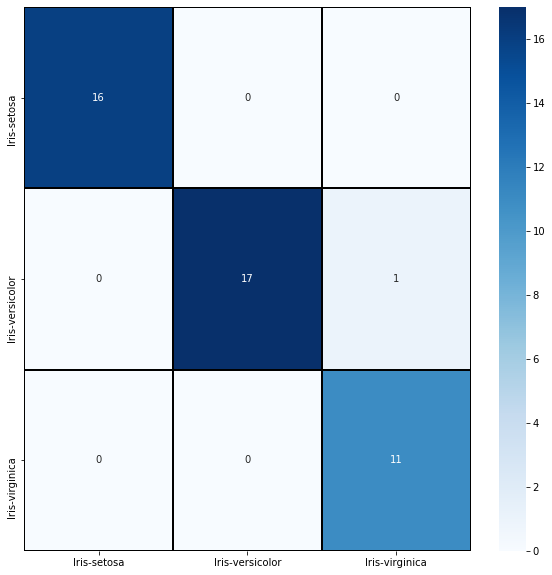

In [49]:
grafico.confunsion_matriz();